In [44]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from astropy.table import QTable
from astroquery.esasky import ESASky
from astropy.nddata import Cutout2D
from astropy.convolution import Gaussian2DKernel, convolve
from astropy import wcs
import matplotlib.pyplot as plt
import pickle

path = "/home/alex/Downloads/"

In [14]:
def background_emission(hmap, map_w, pixel_w, max_sep, get_background):
    '''
    Args:
        hmap: data array
        map_w: width of half the array/map
        pixel_w: size of the pixels
        max_sep: radius of map that will contain the central emission 
        get_background: determines whether to look for background values (boolean)
    Returns:
        hist: array of central pixel values
        means: array of length 20 of mean values of random background areas
    '''
    # Returns the average surface brightness in Jy/pixel of 
    # pixels within max_sep of the center of hmap (assuming hmap has units MJy/pixel)    
    center = map_w + 0.5
    emission = 0
    div = 0
    hist = []
    alpha = []
    delta = []
    for i in range(2*map_w):
        for j in range(2*map_w):
            if pixel_w*np.sqrt((center-i)**2+(center-j)**2) <= max_sep:
                hist.append(hmap[i,j])
                alpha.append(i)
                delta.append(j)
                div +=1
    # Find background flux
    # Randomly choose a point that is at least n RA pixels and m Dec pixels away from the center
    # Shift the circle of pixels that we formed above so that it centers around the random point
    # Calculates the mean of the pixel value in this new, displaced circle
    if get_background:
        means = []
        for k in range(20): # Iterate 20 times
            background_hist = []
            sign_RA = np.random.choice([-1,1]) #Randomize direction of offset
            sign_dec = np.random.choice([-1,1]) 
            offset_RA = sign_RA*(300.-10.)* np.random.random_sample() + 5. #Offset RA between 5 and 70 pixels away
            offset_RA = int(np.round(offset_RA))
            offset_dec = sign_dec * (300.-10.)* np.random.random_sample() + 5. #Offset dec 5 and 70 pixels away
            offset_dec = int(np.round(offset_dec))
            # Take the Circle of pixels around the center of the stamp from above, and shift it
            # with respect to the offset you have randomly settled on
            offset_alpha = []
            offset_delta = []
            for x in range(len(alpha)): 
                offset_alpha.append(alpha[x]+offset_RA)
                offset_delta.append(delta[x]+offset_dec)
            # Record pixel values of the new, displaced circle
            center_RA = center + offset_RA
            center_dec = center + offset_dec
            for i in range(len(offset_alpha)):
                background_hist.append(hmap[offset_alpha[i],offset_delta[i]])
            means.append(np.mean(background_hist))
    return  np.array(hist), np.array(means)

In [15]:
def central_emission(hmap, map_w, pixel_w, max_sep):
    #Returns the average surface brightness in Jy/pixel of pixels within max_sep 
    # of the center of hmap (assuming hmap has units MJy/pixel)
    center = map_w + 0.5
    emission = 0
    div = 0
    hist = []
    for i in range(2*map_w):
        for j in range(2*map_w):
            if pixel_w*np.sqrt((center-i)**2+(center-j)**2) <= max_sep:
                hist.append(hmap[i,j])
                div +=1
    return  np.array(hist)

In [7]:
mdcw = fits.open('/home/alex/Desktop/Clusters/MADCOWSUnion.fits')

mdcwRA = mdcw[1].data['RADeg']
mdcwDec = mdcw[1].data['decDeg']
mdcwName = mdcw[1].data['name']

In [12]:
hdu = fits.open('/home/alex/Downloads/newMoo/'+mdcwName[0])
w = wcs.WCS(hdu[0].header)
header = hdu[0].header
pixel_size = header.get('CDELT2')*u.deg

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [9]:
stackArr = []

In [10]:
# fill stackArr - 998 is weird for moo
i = 0
while i < 1:#len(mdcwRA):
    cutout = fits.open(path + 'newMoo/' + mdcwName[i])
    vmap = cutout[0].data[0][0]
    #Convert from Jy/beam to Jy/pixel
    conv_factor = (np.pi*(2.5/2)**2/np.log(2))
    vmap = (vmap/conv_factor)
    stackArr.append(vmap)
    i+=1
len(stackArr)

In [26]:
# cut excess rows/columns off evens
i = 0
while(i < len(stackArr)):
    if(stackArr[i].shape[0] > 720 and stackArr[i].shape[0] % 2 == 0):
        while(stackArr[i].shape[0] > 720):
            stackArr[i] = np.delete(stackArr[i],stackArr[i].shape[0]-1,0)
            stackArr[i] = np.delete(stackArr[i],0,0)
    if(stackArr[i].shape[1] > 720 and stackArr[i].shape[1] % 2 == 0):
        while(stackArr[i].shape[1] > 720):
            stackArr[i] = np.delete(stackArr[i],stackArr[i].shape[1]-1,1)
            stackArr[i] = np.delete(stackArr[i],0,1)
    i+=1

In [27]:
# cut excess rows/columns off odds
i = 0
while(i < len(stackArr)):
    if(stackArr[i].size > 518400):
        if(stackArr[i].shape[0] > 720 and stackArr[i].shape[0] % 2 != 0):
            if(stackArr[i].shape[0] == 721):
                stackArr[i] = stackArr[i] = np.delete(stackArr[i],stackArr[i].shape[0]-1,0) 
            else:
                while(stackArr[i].shape[0] > 721):
                    stackArr[i] = np.delete(stackArr[i],stackArr[i].shape[0]-1,0)
                    stackArr[i] = np.delete(stackArr[i],0,0)     
                stackArr[i] = stackArr[i] = np.delete(stackArr[i],stackArr[i].shape[0]-1,0) 
        if(stackArr[i].shape[1] > 720 and stackArr[i].shape[1] % 2 != 0):
            if(stackArr[i].shape[1] == 721):
                stackArr[i] = stackArr[i] = np.delete(stackArr[i],stackArr[i].shape[1]-1,1) 
            else:
                while(stackArr[i].shape[1] > 721):
                    stackArr[i] = np.delete(stackArr[i],stackArr[i].shape[1]-1,1)
                    stackArr[i] = np.delete(stackArr[i],0,1)
                stackArr[i] = stackArr[i] = np.delete(stackArr[i],stackArr[i].shape[1]-1,1) 
    i+=1

In [28]:
# array for just 720x720
sevenTwenty = []
# array for indeces
indexArr = []

In [29]:
i = 0
while i < len(stackArr):
    if(stackArr[i].shape == (720,720)):
        sevenTwenty.append(stackArr[i])
        indexArr.append(0+i)
    i+=1
len(sevenTwenty)

In [35]:
i = 0
while i < len(sevenTwenty):
    cent_em = np.mean(central_emission(sevenTwenty[i], int(100), pixel_size.to(u.arcmin).value, 1.0))
    back_em = np.median(background_emission(sevenTwenty[i], int(100), pixel_size.to(u.arcmin).value, 1.0, True)[1])
    thisdict = dict('name': mdcwName[indexArr[i]],'source flux': cent_em,'background flux': back_em)
    i+=1

In [124]:
pickle.dump(dictionary, open(path+"mooEmissionCatalog.pickle","wb"))

In [37]:
done = pickle.load(open(path+"mooEmissionCatalog.pickle","rb"))

In [40]:
print(done[0])

{'MOO J0001+1428': [-8.8941675e-08, 6.816236e-08]}


In [ ]:
# ignore the rest

In [198]:
i = 0
dictionary = []
while i < len(txtArr):
    a = {txtArr[i][0:14]:float(txtArr[i][16:])}
    dictionary.append(a)
    i+=1

In [199]:
textArr = np.array(dictionary)
a_file = open("/home/alex/Downloads/madcowsCentralFlux.txt","w")
np.savetxt(a_file, textArr,fmt='%s',newline = ',\n')

a_file.close()

In [8]:
# define stacker
def s18dStack(ras, decs, width = 20., weight = False):
    stack = 0
    divisor = 0
    count = 0

    while(divisor < len(stackArr)):
        if len(stackArr[divisor]) == 720 and len(stackArr[divisor][0]) == 720:
            stack += stackArr[divisor]
            count +=1
        divisor += 1

    print("Number in stack: {}".format(count))
    return stack, count

In [9]:
# extent in arcmin for plot axes
w1 = -720*pixel_size.to(u.arcmin)/2
x1 = 720*pixel_size.to(u.arcmin)/2
y1 = -720*pixel_size.to(u.arcmin)/2
z1 = 720*pixel_size.to(u.arcmin)/2

Number in stack: 1652


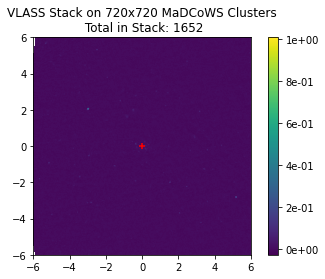

In [10]:
# stacker
s18d_stack, stack_num = s18dStack(mdcwRA, mdcwDec)

out, cen, cen_d, out_d = 0,0,0,0

#plot stack
plot = plt.imshow(s18d_stack, extent = [w1.value,x1.value,y1.value,z1.value])
plt.scatter(0,0, marker = '+', color = 'r')
plt.colorbar(plot, format='%.0e')
plt.title("VLASS Stack on 720x720 MaDCoWS Clusters\n Total in Stack: {}".format(stack_num))
#plt.savefig("vlass_stacks_on_mdcws.pdf")
plt.show()
plt.close()

In [11]:
# give units back to vmap
vmap = s18d_stack*(u.Jy/u.beam)

#Convert from Jy/beam to Jy/pixel
conv_factor = (np.pi*(2.5/2)**2/np.log(2))*(u.pix/u.beam)
vmap = (vmap/conv_factor)

#Smoothing map
filt_scale = 1*u.arcmin
beam_fwhm = 2.5*u.arcsec
smooth_scale = np.sqrt(filt_scale**2-beam_fwhm.to(u.arcmin)**2)

filt_pix = np.round(smooth_scale/pixel_size.to(u.arcmin))
kernel = Gaussian2DKernel(x_stddev =  filt_pix)

hdata = convolve(vmap, kernel) * (u.Jy/u.pix)

In [12]:
# saving stacked array as text file
# np.savetxt('/home/alex/Downloads/stackedSmoothedVLASSdata', hdata.value)
# b = np.loadtxt('/home/alex/Downloads/stackedSmoothedVLASSdata')
# plt.imshow(b)

AttributeError: 'Quantity' object has no 'get_array' member

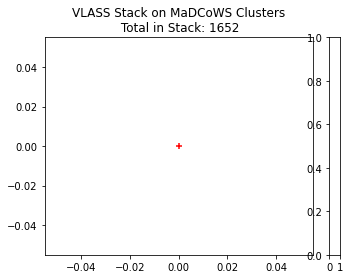

In [13]:
# plot smoothed stack
plt.title("VLASS Stack on MaDCoWS Clusters\n Total in Stack: {}".format(stack_num))
plt.scatter(0,0, marker = '+', color = 'r')
plt.colorbar(hdata)
plt.imshow(hdata, extent = [w1.value,x1.value,y1.value,z1.value])
#plt.savefig("/home/alex/Downloads/vlassStackOnMadcows.pdf",bbox_inches='tight')

In [8]:
# histogram

In [20]:
emissionStack = []

In [18]:
# fill emission stack with flux values for histogram
# emissionStack = []
i = 0
while i < len(stackArr):
    try:
        cent_em = central_emission(stackArr[i], int(100), pixel_size.to(u.arcmin).value, 1.0)
        emissionStack.append(np.sum(cent_em))
    except:
        pass
    i+=1

In [19]:
len(emissionStack)

1378

In [47]:
emissionStackArr = np.array(emissionStack)
a_file = open("/home/alex/Downloads/test.txt","w")
np.savetxt(a_file, emissionStackArr)

a_file.close()

In [15]:
# fill values for histStack ... cut out values below VLASS noise floor
histStack = []
i = 0
while i < len(emissionStack):
    if(emissionStack[i] > 6.9E-5):#combined (3 epoch) sensitivity 69microJy RMS
        histStack.append(emissionStack[i])
    i+=1

In [18]:
len(histStack)

NameError: name 'histStack' is not defined

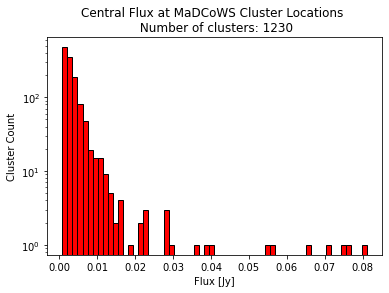

In [17]:
plt.hist(histStack,bins=60,align='right',edgecolor='black',color='red')
plt.xlabel('Flux [Jy]')
plt.ylabel('Cluster Count')
plt.yscale('log')
plt.title('Central Flux at MaDCoWS Cluster Locations \n Number of clusters: ' + str(len(histStack)))
plt.savefig("/home/alex/Downloads/madcowsHistogram.pdf",bbox_inches='tight')
plt.show()

In [19]:
len(histStack)

1230

In [18]:
# pick out central emission >300mJy
i = 0
while i < len(histStack):
    if(histStack[i] > .3):
        print(str(i))
    i+=1

In [ ]:
# central emission #hdata
# cent_em = central_emission(stackArr[0], int(100), pixel_size.to(u.arcmin).value, 1.0)
# print(np.mean(cent_em), np.std(cent_em))
# print(np.mean(hdata), np.std(hdata))

In [8]:
# emissionStack = []

In [6]:
# i = 0
# while i < len(stackArr):
#     if(stackArr[i].shape == (720,720)):
#         cent_em = central_emission(stackArr[i], int(100), pixel_size.to(u.arcmin).value, 1.0)
#         emissionStack.append(np.sum(cent_em))
#     i+=1

In [7]:
# len(emissionStack)

In [8]:
# i = 0
# histStack = []
# while i < len(emissionStack):
#     if(emissionStack[i] > .0025):
#         histStack.append(emissionStack[i])
#     i+=1

In [9]:
# len(histStack)

In [10]:
# plt.hist(histStack,bins=60,align='right',edgecolor='black',color='red')
# plt.xlabel('Flux [Jy]')
# plt.ylabel('Cluster Count')
# plt.yscale('log')
# plt.title('Central Flux at MaDCoWS Cluster Locations \n Number of clusters: ' + str(len(histStack)))
# plt.savefig("/home/alex/Downloads/madcowsHistogram.pdf",bbox_inches='tight')
# plt.show()

In [ ]:
# the rest are just notes

In [27]:
# pixel_area = (pixel_size**2).to(u.sr)

# print(pixel_area)

In [28]:
# vmap = vmap*pixel_area
# print(vmap[0,0])

In [29]:
# print(vmap)
# stamp = Cutout2D(vmap, (int(723/2),int(724/2)), 200. , mode = 'strict')

# fig, axes = plt.subplots()

# plt.imshow(stamp.data.value)
# draw_circle = plt.Circle((100, 100), 50, color = 'r',fill=False, alpha = 0.5)

# plt.colorbar()

# axes.set_aspect(1)
# axes.add_artist(draw_circle)

In [30]:
# fwhm = 6*u.arcsec
# omega_B = np.pi * (fwhm/2)**2/np.log(2)
# print((vmap*u.Jy/u.beam).to(u.MJy/u.sr,equivalencies=u.beam_angular_area(omega_B)))

In [31]:
# vmap = vmap*pixel_area
# print(vmap[0,0])

In [32]:
# cent_em = central_emission(vmap, int(100),pixel_size.to(u.arcmin).value,1.0)

# aperture_area = np.pi*(1.0*u.arcmin)**2
# average_flux = cent_em[0]/aperture_area

# print(average_flux.to(u.MJy/u.sr))

# map_var_Jy = np.std(vmap[150:199, 0:199])/pixel_area.unit
# map_var = (map_car_Jy).to(u.MJy/u.sr)
# print(map_var)

In [ ]:
# how to read text files I sent to Jack

In [76]:
# path = "/home/alex/Downloads/"

# mooFile = open(path + "madcowsCentralFlux.txt",'r')
# mooLines = mooFile.readlines()

# actFile = open(path + "actCentralFlux.txt",'r')
# actLines = actFile.readlines()

# mooNameArr = [] # moo names stored here
# mooFluxArr = [] # moo fluxes stored here
# for line in mooLines:
#     mooNameArr.append(line.strip()[2:15])
#     mooFluxArr.append(float(line.strip()[18:len(line.strip())-2]))

# actNameArr = [] # act names stored here
# actFluxArr = [] # act fluxes stored here
# for line in actLines:
#     actNameArr.append(line.strip()[2:20])
#     actFluxArr.append(float(line.strip()[23:len(line.strip())-2]))

In [ ]:
# old central emission
# def central_emission(hmap, map_w, pixel_w, max_sep):
#     #Returns the average surface brightness in Jy/pixel of pixels within max_sep 
#     # of the center of hmap (assuming hmap has units MJy/pixel)
#     center = map_w + 0.5
#     emission = 0
#     div = 0
#     hist = []
#     for i in range(2*map_w):
#         for j in range(2*map_w):
#             if pixel_w*np.sqrt((center-i)**2+(center-j)**2) <= max_sep:
#                 hist.append(hmap[i,j])
#                 div +=1
#     return  np.array(hist)

In [ ]:
#old attempt at naming central emission clusters

In [ ]:
# nameArr = []
# j = 0
# while j < 2603:
    
#     if(j == 1059 or j == 2544):
#         hdu = fits.open('/home/alex/Downloads/moo/'+mdcwName[j])
#         header = hdu[0].header
#         obsRA = header.get('OBSRA')
#         obsDec = header.get('OBSDEC')

#         done = False
#         sep = .8
#         while(done == False):
#             i = 0
#             num = []
#             while i < len(mdcwName):
#                 if(mdcwRA[i] < obsRA+sep and mdcwRA[i] > obsRA-sep and mdcwDec[i] < obsDec+sep and mdcwDec[i] > obsDec-sep):
#                     #print("real one is " + str(obsRA) + " " + str(obsDec))
#                     #print(mdcwRA[i], mdcwDec[i])
#                     num.append(i)
#                 i+=1
#             if(len(num) == 1):
#                 done = True
#             elif(len(num) == 0):
#                 sep +=.0001
#             else:
#                 sep -=.0001
#         name = mdcwName[num[0]]
#         nameArr.append(name)
#         print(str(j) + " complete")
#         j+=1
                
#     hdu = fits.open('/home/alex/Downloads/moo/'+mdcwName[j])
#     header = hdu[0].header
#     obsRA = header.get('OBSRA')
#     obsDec = header.get('OBSDEC')
    
#     done = False
#     sep = .8
#     while(done == False):
#         i = 0
#         num = []
#         while i < len(mdcwName):
#             if(mdcwRA[i] < obsRA+sep and mdcwRA[i] > obsRA-sep and mdcwDec[i] < obsDec+sep and mdcwDec[i] > obsDec-sep):
#                 num.append(i)
#             i+=1
#         if(len(num) == 1):
#             done = Truepickle.dump(favorite_color, open(path+"save.pickle","wb"))
#         elif(len(num) == 0):
#             sep +=.005
#         else:
#             sep -=.005
    
#     name = mdcwName[num[0]]
#     nameArr.append(name)
#     print(str(j) + " complete")
#     j+=1

In [ ]:
#old attempt at pickle
# cutout = fits.open('/home/alex/Downloads/moo/'+mdcwName[i])
# vmap = cutout[0].data[0][0]
# #Convert from Jy/beam to Jy/pixel
# conv_factor = (np.pi*(2.5/2)**2/np.log(2))
# vmap = (vmap/conv_factor)
# cent_em = central_emission(vmap.data, int(100), pixel_size.to(u.arcmin).value, 1.0)
# toBePickled = {nameArr[i]: np.sum(cent_em)}
# pickle.dump(toBePickled,open(path+"save.p","wb"))